# Abbildungen zur Bestimmung der Phasengeschwindigkeit

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os

In [64]:
path_romy = "C:/Bachelorarbeit/figures/acc/ROMYRLAS/"
path_fur = "C:/Bachelorarbeit/figures/acc/FURWET/"
path_fig = "C:/Bachelorarbeit/figures/acc/"
df_TFUR = pd.read_csv(path_fur + "amp_ergebnisse_T.csv")
df_ZFUR = pd.read_csv(path_fur + "amp_ergebnisse_Z.csv")
df_ZROMY = pd.read_csv(path_romy + "amp_ergebnisse_Z.csv")
font_title=17
font_ax=13
font_leg=11
log=True

In [65]:
def plot_curve(ax, df, prefix, scale, color, label, num_events=None, zorder=None, 
               outlier_filter=True, z_thresh=3, use_median=True):
    import re
    import numpy as np

    # Spalten mit dem richtigen Präfix finden
    ratio_cols = [col for col in df.columns if col.startswith(prefix)]
    
    # Frequenzen extrahieren (robust mit Regex)
    frequencies = [
        float(re.search(r"_(\d+\.\d+)Hz", col).group(1))
        for col in ratio_cols
    ]

    # Optional: Ausreißer filtern (Z-Score)
    if outlier_filter:
        df_filtered = df.copy()
        mask = pd.Series(True, index=df.index)  # Start: alle Zeilen behalten
        for col in ratio_cols:
            z_scores = (df[col] - df[col].mean()) / df[col].std()
            mask &= (z_scores.abs() < z_thresh)  # nur Zeilen behalten, die für alle Spalten passen
        df_filtered = df[mask]
    else:
        df_filtered = df


    # Anzahl Events bestimmen (falls nicht gegeben)
    if num_events is None:
        num_events = len(df_filtered)

    # Median + richtige MAD oder Mean + SEM
    if use_median:
        center = df_filtered[ratio_cols].median() * scale
        # eigene Funktion für Median Absolute Deviation
        mad = df_filtered[ratio_cols].apply(lambda x: np.median(np.abs(x - np.median(x)))) * scale
        spread = mad
    else:
        center = df_filtered[ratio_cols].mean() * scale
        spread = df_filtered[ratio_cols].sem() * scale  # Klassisch: SEM

    # Arrays erstellen und nach Frequenz sortieren
    sort_idx = np.argsort(frequencies)
    freq_array = np.array(frequencies)[sort_idx]
    center_array = center.values[sort_idx]
    spread_array = spread.values[sort_idx]

    # Plot
    ax.plot(freq_array, center_array, color=color, linewidth=2,
            label=f"{label} (n = {num_events})", zorder=zorder)
    ax.fill_between(freq_array, center_array - spread_array, center_array + spread_array,
                    color=color, alpha=0.3, zorder=zorder)


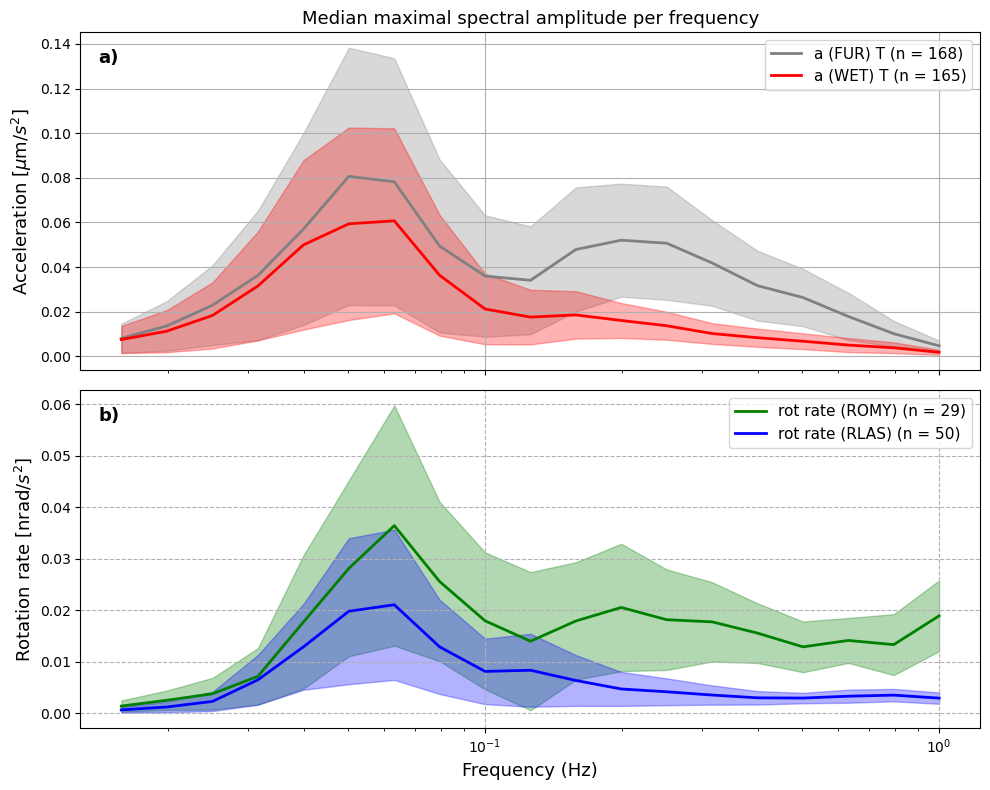

In [66]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)

plot_curve(ax1, df_TFUR, prefix="amp1_", scale=1e6, color='gray', label='a (FUR) T')
plot_curve(ax1, df_TFUR, prefix="amp2_", scale=1e6, color='red', label='a (WET) T')

ax1.set_ylabel("Acceleration [$\mu$m/$s^2$]", color='black', fontsize=font_ax)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)
ax1.legend(loc='best', fontsize=font_leg)
ax1.set_title("Median maximal spectral amplitude per frequency", fontsize=font_ax)
ax1.text(0.02, 0.95, "a)", transform=ax1.transAxes, fontsize=font_ax, fontweight='bold', va='top')
plot_curve(ax2, df_ZROMY, prefix="amp1_", scale=1e9, color='green', label='rot rate (ROMY)', num_events=29)
plot_curve(ax2, df_ZROMY, prefix="amp2_", scale=1e9, color='blue', label='rot rate (RLAS)')
ax2.text(0.02, 0.95, "b)", transform=ax2.transAxes, fontsize=font_ax, fontweight='bold', va='top')

ax2.set_xlabel("Frequency (Hz)", fontsize=font_ax)
ax2.set_ylabel("Rotation rate [nrad/$s^2$]", color='black', fontsize=font_ax)
ax2.tick_params(axis='y', labelcolor='black')
ax2.grid(True, linestyle='--')
# ax2.set_ylim(0, 0.25)
ax2.legend(loc='best', fontsize=font_leg)
# Achsenskalierung
if log:
    ax2.set_xscale('log')
    para = "log"
else:
    para = "norm"

plt.tight_layout()
plt.savefig(os.path.join(path_fig, f"spectral amplitude per frequency 2 subplots {para}.png"), dpi=300)
plt.show()


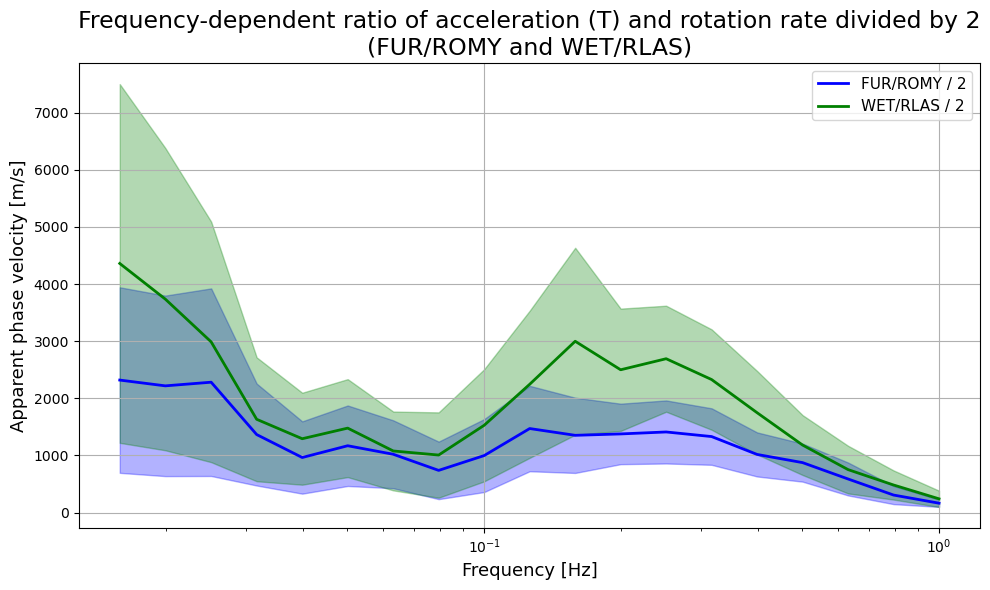

In [67]:
def filter_iqr(df, cols, k=1.5):
    """
    Entfernt Zeilen aus df, die in den angegebenen cols Ausreißer enthalten (IQR-Filter).
    """
    mask = pd.Series(True, index=df.index)  # Start: alle True
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        mask &= df[col].between(lower, upper)  # nur Zeilen innerhalb des Bereichs behalten
    return df[mask]

def mad(series):
    """
    Berechnet die Median Absolute Deviation (MAD).
    """
    median = np.median(series)
    return np.median(np.abs(series - median))

# -----------------------------
# Daten laden
# -----------------------------
df1 = pd.read_csv(path_fur + "amp_ergebnisse_T.csv")
df2 = pd.read_csv(path_romy + "amp_ergebnisse_Z.csv")

# Spalten extrahieren und sortieren
amp1_cols = sorted([col for col in df1.columns if col.startswith("amp1_")])
amp2_cols = sorted([col for col in df1.columns if col.startswith("amp2_")])

# Optional: IQR-Filter anwenden
df1_filtered = filter_iqr(df1, amp1_cols + amp2_cols, k=1.5)
df2_filtered = filter_iqr(df2, amp1_cols + amp2_cols, k=1.5)

# Mediane und MAD über alle Events hinweg
amp1_median_df1 = df1_filtered[amp1_cols].median()
amp1_median_df2 = df2_filtered[amp1_cols].median()
amp2_median_df1 = df1_filtered[amp2_cols].median()
amp2_median_df2 = df2_filtered[amp2_cols].median()

amp1_mad_df1 = df1_filtered[amp1_cols].apply(mad)
amp1_mad_df2 = df2_filtered[amp1_cols].apply(mad)
amp2_mad_df1 = df1_filtered[amp2_cols].apply(mad)
amp2_mad_df2 = df2_filtered[amp2_cols].apply(mad)

# Verhältnis: df1 / df2 und Skalierung
amp1_ratio = (amp1_median_df1.values / amp1_median_df2.values) * 0.5
amp2_ratio = (amp2_median_df1.values / amp2_median_df2.values) * 0.5

# Fehlerbalken (propagierte MADs)
amp1_ratio_mad = (amp1_mad_df1.values / amp1_median_df2.values) * 0.5
amp2_ratio_mad = (amp2_mad_df1.values / amp2_median_df2.values) * 0.5

# Frequenzen extrahieren und sortieren
frequencies = [float(col.split("_")[1][:-2]) for col in amp1_cols]
frequencies = np.array(frequencies)
sort_idx = np.argsort(frequencies)

# Sortieren
frequencies_sorted = frequencies[sort_idx]
amp1_ratio_sorted = amp1_ratio[sort_idx]
amp2_ratio_sorted = amp2_ratio[sort_idx]
amp1_ratio_mad_sorted = amp1_ratio_mad[sort_idx]
amp2_ratio_mad_sorted = amp2_ratio_mad[sort_idx]

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 6))

# Plot mit Median
plt.plot(frequencies_sorted, amp1_ratio_sorted, label="FUR/ROMY / 2", color="blue", linewidth=2)
plt.fill_between(frequencies_sorted, 
                 amp1_ratio_sorted - amp1_ratio_mad_sorted, 
                 amp1_ratio_sorted + amp1_ratio_mad_sorted,
                 color="blue", alpha=0.3)

plt.plot(frequencies_sorted, amp2_ratio_sorted, label="WET/RLAS / 2", color="green", linewidth=2)
plt.fill_between(frequencies_sorted, 
                 amp2_ratio_sorted - amp2_ratio_mad_sorted, 
                 amp2_ratio_sorted + amp2_ratio_mad_sorted,
                 color="green", alpha=0.3)

if log:
    plt.xscale('log')
    para = "log"
else:
    para = "norm"

plt.xlabel("Frequency [Hz]", fontsize=font_ax)
plt.ylabel("Apparent phase velocity [m/s]", fontsize=font_ax)
plt.title("Frequency-dependent ratio of acceleration (T) and rotation rate divided by 2\n(FUR/ROMY and WET/RLAS)", fontsize=font_title)
plt.grid(True)
plt.legend(fontsize=font_leg)
plt.tight_layout()
plt.savefig(path_fig + f"Phasengeschwindigkeit_robust_gg_Frequenz_{para}.png", dpi=300)
plt.show()


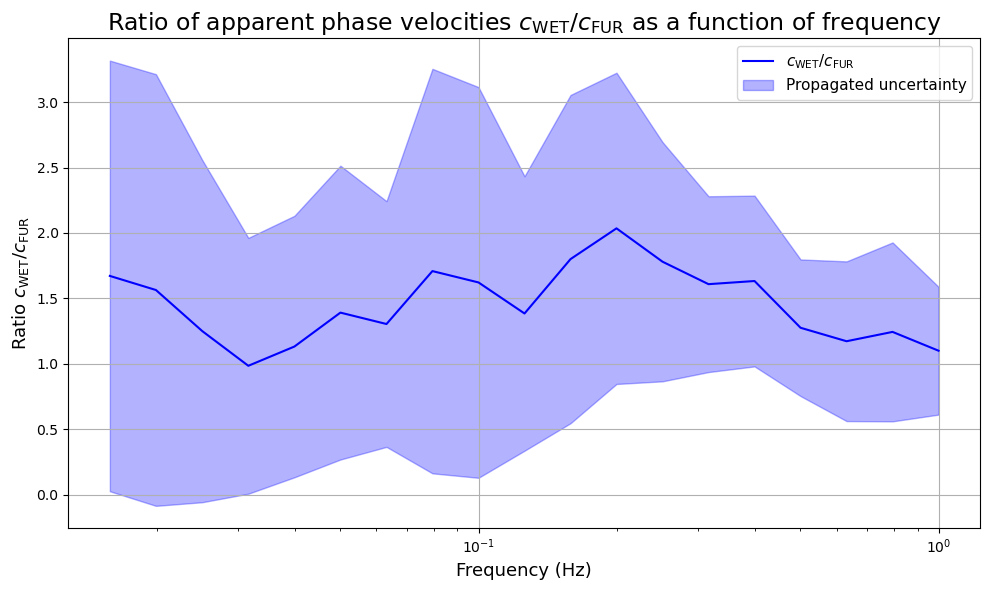

In [68]:
plt.figure(figsize=(10, 6))

# Plot the ratio curve
plt.plot(
    frequencies_sorted, ratio1,
    label="$c_{\\mathrm{WET}} / c_{\\mathrm{FUR}}$",
    color='blue'
)

# Classical Gaussian error propagation
# relative errors squared and summed
relative_error_sq = (
    (amp1_mad_df1.values[sort_idx] / amp1_median_df1.values[sort_idx])**2 +
    (amp2_mad_df2.values[sort_idx] / amp2_median_df2.values[sort_idx])**2
)

# Propagated uncertainty
ratio_uncertainty = ratio1 * np.sqrt(relative_error_sq)

# Upper and lower bounds
upper = ratio1 + ratio_uncertainty
lower = ratio1 - ratio_uncertainty

# Add shaded uncertainty area
plt.fill_between(
    frequencies_sorted, lower, upper,
    color='blue', alpha=0.3,
    label="Propagated uncertainty"
)

# Labels and title in English
plt.xlabel("Frequency (Hz)", fontsize=font_ax)
plt.ylabel("Ratio $c_{\\mathrm{WET}} / c_{\\mathrm{FUR}}$", fontsize=font_ax)
plt.title(
    "Ratio of apparent phase velocities $c_{\\mathrm{WET}} / c_{\\mathrm{FUR}}$ as a function of frequency",
    fontsize=font_title
)
plt.grid(True)

# Logarithmic x-axis if desired
if log:
    plt.xscale('log')
    para = "log"
else:
    para = "linear"

plt.legend(fontsize=font_leg)
plt.tight_layout()
plt.savefig(path_fig + f"PhaseVelocity_Ratio_vs_Frequency_{para}.png", dpi=300)
plt.show()
